2022-05-05 00:05:31.395726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 00:05:31.852096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 00:05:31.907098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 00:05:31.990207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 00:05:32.041093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


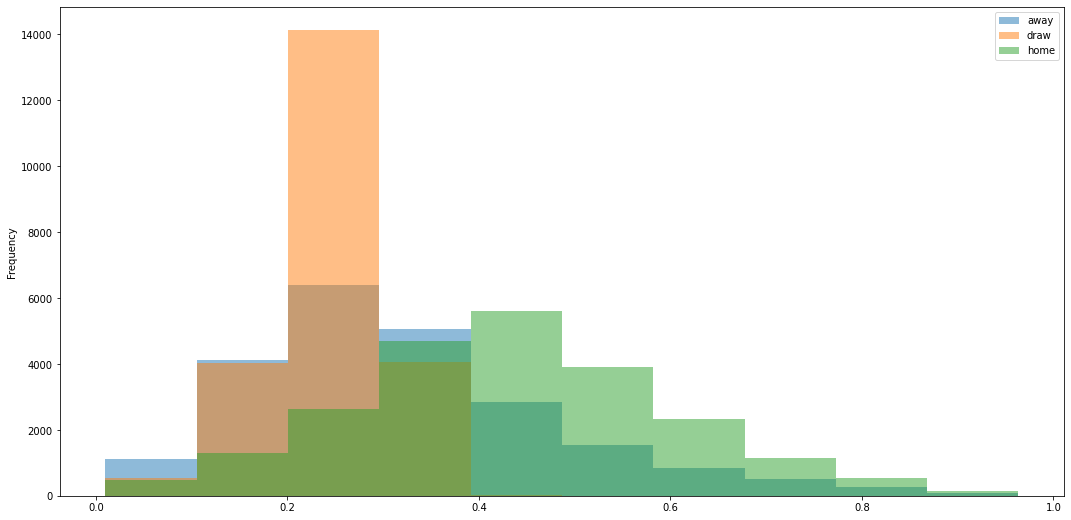

In [2]:
import tensorflow as tf
import pandas as pd
from data_processing import data_convert
from sklearn import preprocessing
import matplotlib.pylab as plt

mask = -999.0
timesteps = 10
historical_features = [
    # home based
    'home_team_history_goal',
    'home_team_history_opponent_goal',
    'home_team_history_is_play_home', 
    'home_team_history_rating',
    'home_team_history_opponent_rating',
    'home_team_history_match_days_ago',
    'home_team_history_same_coach',
    'home_team_history_same_league',
        
    # away based
    'away_team_history_goal', 
    'away_team_history_opponent_goal',
    'away_team_history_rating',
    'away_team_history_opponent_rating',
    'away_team_history_match_days_ago',
    'away_team_history_same_coach',
    'away_team_history_same_league'
] 
test = pd.read_csv('../data/X_test.csv')
features_pattern = '_[0-9]|'.join(historical_features) + '_[0-9]'
features_to_preprocess = test.filter(regex=features_pattern, axis=1).columns.tolist()
scaler = preprocessing.RobustScaler()
X_test_pre = pd.DataFrame(scaler.fit_transform(test[features_to_preprocess]), columns=features_to_preprocess)
X_test = pd.concat([test[['id', 'league_name']], X_test_pre], axis=1)
X_test = pd.concat([
        data_convert(X_test, feature=feature, timesteps=timesteps, mask = mask, historical_features = historical_features) for feature in historical_features
    ], axis=1).values.reshape(-1, timesteps, len(historical_features))
model = tf.keras.models.load_model('../data/dumps/model.h5')
probs_test = model.predict(X_test)
results = pd.DataFrame({
    'id': test['id'],
    'away': probs_test[:, 0],
    'draw': probs_test[:, 1],
    'home': probs_test[:, 2]
})
results.iloc[:,1:].plot.hist(alpha=0.5,figsize=(18,9))
results.to_csv("../data/X_test_results.csv", index=False, sep=',')
